Manual Preprocessing: Mask Irregular
====================================

In [1]:
%matplotlib inline
from pyprojroot import here
workspace_path = str(here())
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

from os import path
import autolens as al
import autolens.plot as aplt
import numpy as np

/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace
Working Directory has been set to `/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace`


This tool allows one to mask a bespoke mask for a given image of a strong lens, which can then be loaded
before a pipeline is run and passed to that pipeline so as to become the default masked used by a phase (if a mask
function is not passed to that phase).

This tool creates an irregular mask, which can form any shape and is not restricted to circles, annuli, ellipses,
etc. This mask is created as follows:

1) Blur the observed image with a Gaussian kernel of specified FWHM.
2) Compute the absolute S/N map of that blurred image and the noise-map.
3) Create the mask for all pixels with a S/N above a theshold value.

For strong lenses without a lens light component this masks create a source-only mask. If the lens light is included
it includes the lens light and source.

The following parameters determine the behaviour of this function:

The sigma value (e.g. FWHM) of the Gaussian the image is blurred with and the S/N threshold defining above which a 
image-pixel value must be to not be masked.

In [2]:
blurring_gaussian_sigma = 0.1
signal_to_noise_threshold = 10.0

Setup the path the datasets we'll use to illustrate preprocessing, which is the 
folder `dataset/imaging/preprocess/mass_sie__source_sersic`.

In [3]:
dataset_name = "mass_sie__source_sersic"
dataset_path = path.join("dataset", "imaging", "no_lens_light", dataset_name)

image = al.Array2D.from_fits(
    file_path=path.join(dataset_path, "image.fits"), pixel_scales=0.1
)
noise_map = al.Array2D.from_fits(
    file_path=path.join(dataset_path, "noise_map.fits"), pixel_scales=0.1
)

Returns the 2D Gaussian that the image is blurred with. This blurring smooths over noise in the image, which will 
otherwise lead unmasked values with in individual pixels if not smoothed over correctly.

In [4]:
blurring_gaussian = al.Kernel2D.from_gaussian(
    shape_native=(31, 31),
    pixel_scales=image.pixel_scales,
    sigma=blurring_gaussian_sigma,
)

Blur the image with this Gaussian smoothing kernel and plot the resulting image.

In [5]:
blurred_image = blurring_gaussian.convolved_array_from_array(array=image)
aplt.Array2DPlotter(array=blurred_image)

Now compute the absolute signal-to-noise map of this blurred image, given the noise-map of the observed dataset.

In [6]:
blurred_signal_to_noise_map = blurred_image / noise_map
aplt.Array2DPlotter(array=blurred_signal_to_noise_map)

Now create the mask in 2ll pixels where the signal to noise is above some threshold value.

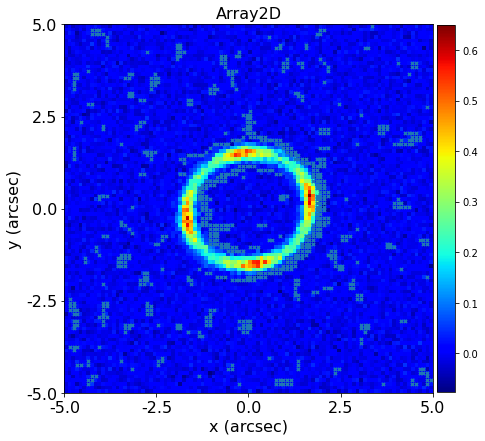

In [7]:
mask = np.where(
    blurred_signal_to_noise_map.native > signal_to_noise_threshold, False, True
)
mask = al.Mask2D.manual(mask=mask, pixel_scales=image.pixel_scales, sub_size=1)

visuals_2d = aplt.Visuals2D(mask=mask)
array_plotter = aplt.Array2DPlotter(array=image, visuals_2d=visuals_2d)
array_plotter.figure()

Now we`re happy with the mask, lets output it to the dataset folder of the lens, so that we can load it from a .fits
file in our pipelines!